# Homework 8:  Resampling methods
This homework assignment is designed to give you practice with bootstrapping and permutation tests.

​
You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

​
This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only includes the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [8]:
# WRITE YOUR CODE HERE
library(tidyverse)
data <- read.csv('unrestricted_trimmed_1_7_2020_10_50_44.csv')
d1 <- data %>% select(Subject, Gender, Flanker_Unadj, FS_IntraCranial_Vol, FS_Tot_WM_Vol, FS_Total_GM_Vol) %>% drop_na()
levels(data$Gender)

[1] "F" "M"

(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). What pattern do you see?

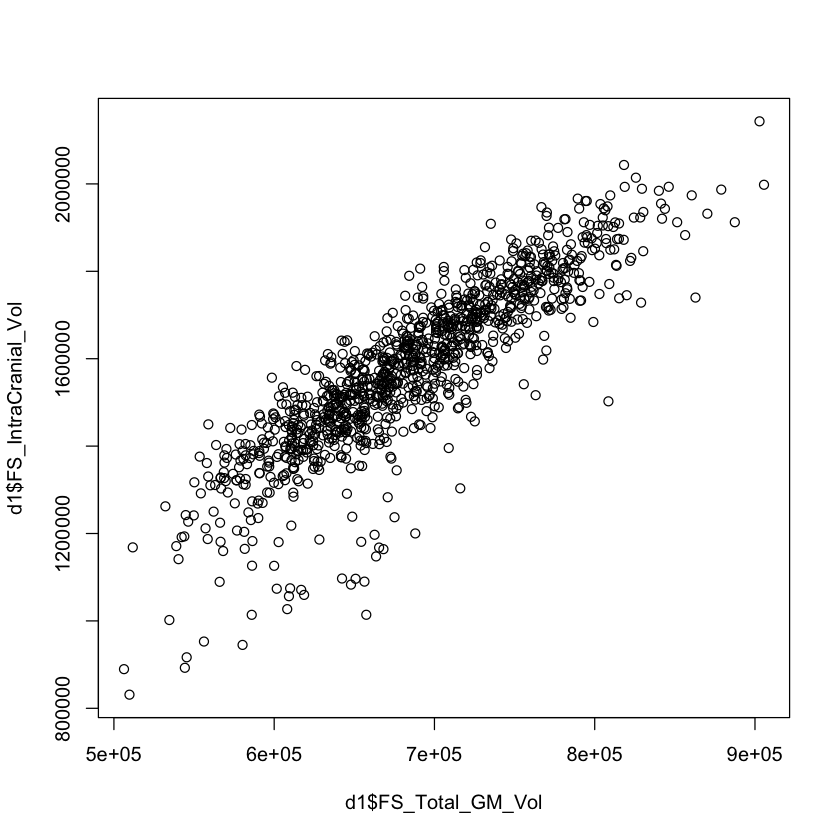

In [5]:
# WRITE YOUR CODE HERE
plot(d1$FS_Total_GM_Vol,d1$FS_IntraCranial_Vol)

What patterns do you observe in the scatter plot?

> The 2 features are highly correlated.

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [6]:
# WRITE YOUR CODE HERE
mylogit.fit <- glm(Gender ~  FS_Tot_WM_Vol + FS_Total_GM_Vol, data = d1, family = "binomial")
summary(mylogit.fit)


Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol, family = "binomial", 
    data = d1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8329  -0.6437  -0.2096   0.6132   2.8342  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.258e+01  1.340e+00 -16.854  < 2e-16 ***
FS_Tot_WM_Vol    7.634e-06  2.741e-06   2.784  0.00536 ** 
FS_Total_GM_Vol  2.758e-05  2.628e-06  10.496  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  940.43  on 1110  degrees of freedom
AIC: 946.43

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> Total grey matter volume is significantly associated with gender. If we consider a significance cutoff of 0.05 then total white matter volume can be said to be significantly associated with gender too but to a lesser degree when compared to total grey matter volume. 

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [50]:
# WRITE YOUR CODE HERE
get_accuracy <- function(logit, actual_labels){
    glm_prob_df = data.frame(predict(logit, type = "response"))
    colnames(glm_prob_df) = c('predicted_prob')
    glm_prob_df$predicted_binary=rep('F',nrow(glm_prob_df))
    glm_prob_df$predicted_binary = factor(glm_prob_df$predicted_binary,levels=c('F','M'))

    # if greater than threshold set it as Male
    glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>0.5]='M'
    confusion_df = data.frame(glm_prob_df$predicted_binary, actual_labels)
    colnames(confusion_df) = c('predicted', 'actual')
    return(mean(confusion_df$predicted == confusion_df$actual))
}
A = get_accuracy(mylogit.fit,d1$Gender)

What is the prediction accuracy for gender from the full model?

>The accuracy is 0.8.

## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model. Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


In [17]:
# WRITE YOUR CODE HERE
library(boot)
boot.fn <- function(data, index){  
    # return: throw this as output
    # coef: extract coefficients from model object 
    return(get_accuracy(glm(Gender ~  FS_Tot_WM_Vol + FS_Total_GM_Vol, data=data, subset=index, family = "binomial"),d1$Gender[index]))}
boot_obj = boot(d1 ,boot.fn ,R=1000) 
print(boot_obj)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d1, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.8059299 0.002488769  0.01231232


[1] "Confidence interval for prediction accuracy : (0.793618,0.818242)"

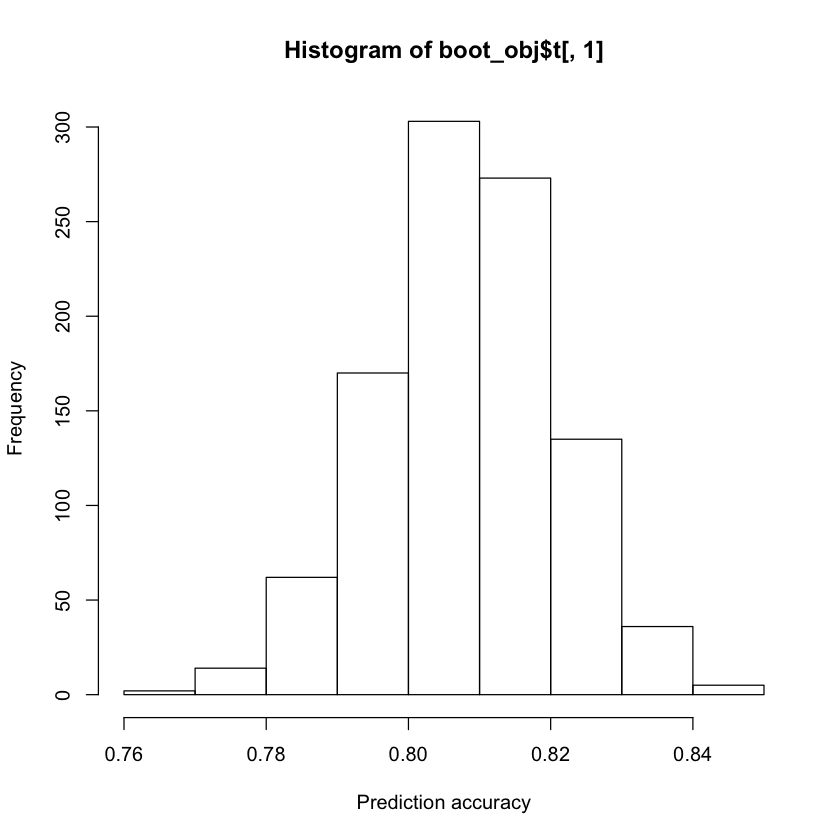

In [26]:
hist(boot_obj$t[,1], xlab="Prediction accuracy")
# CI  = all data accuracy +- std(of plotted histogram distribution)
sprintf("Confidence interval for prediction accuracy : (%f,%f)",A - sd(boot_obj$t[,1]),A + sd(boot_obj$t[,1]))

How robust is the prediction accuracy of the full model?

> Given the small range of the confidence interval(CI), we can say that our accuracy estimate is very robust. A smaller CI indicates a smaller margin of error. 

## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

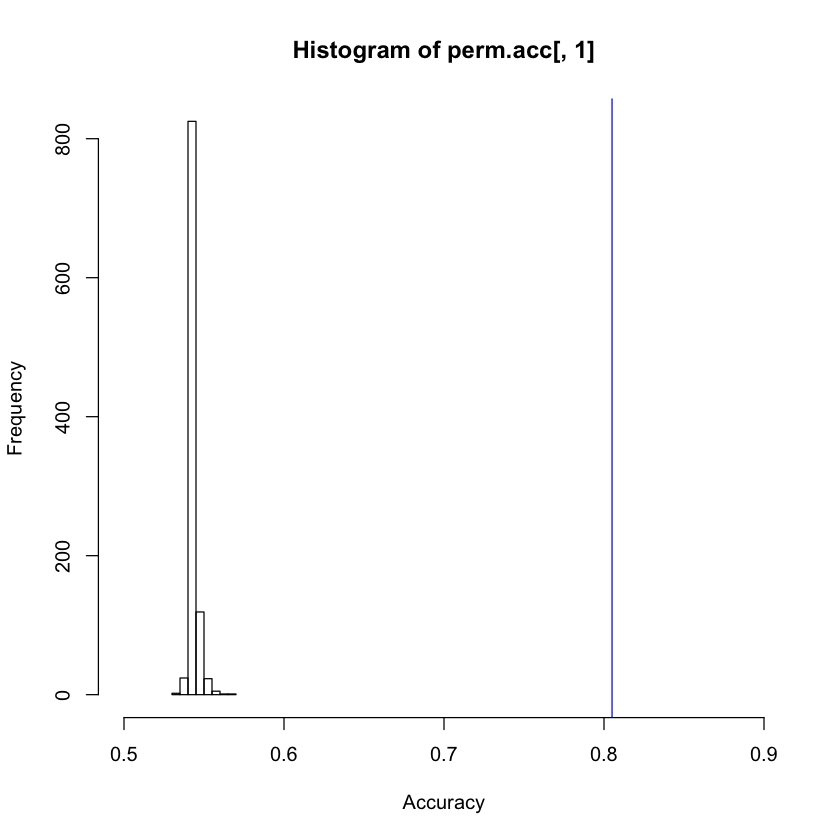

In [58]:
# WRITE YOUR CODE HERE

perm.data = d1
R=1000
perm.acc=matrix(NA,nrow=R, ncol=1)
for (i in 1:R){
    perm.data$Gender = d1$Gender[sample(nrow(d1))]
    perm.acc[i,] = get_accuracy(glm(Gender ~ FS_Total_GM_Vol, data=perm.data, family = "binomial"),perm.data$Gender)
}
# real accuracy with GM_Vol
acc = get_accuracy(glm(Gender ~ FS_Total_GM_Vol, data=d1, family = "binomial"),d1$Gender)
hist(perm.acc[,1], xlab="Accuracy",xlim=range(c(0.5,0.9)))
abline(v=acc, col="blue")

How much does the grey matter volume influence the prediction accuracy of the model?

> An accuracy of 0.8 is obtained by training a logistic regression model only on grey matter volume. When compared against a null distribution indicating no effect on accuracy, the model's accuracy value is way outside the range of values obtained from the permutation tests. This indicates that the grey matter volume significantly contributes towards predicting Gender.

## Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> Primary difference in terms of implementation is sampling with replacement for bootstrapping and without replacement for permutation test. 
While the former is used to generate the sampling distribution for the input data, the latter is use
Bootstrapping estimates the variability and hence is used for estimating confidence intervals for a statistic. Permutation tests are used to test hypothesis like if the effect can be explained by random data.


**DUE:** 5pm EST, April 8, 2021

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*